549


W1010 21:13:02.564968 140340483254016 deprecation.py:506] From /home/skuznik/local/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(114855, 14, 14, 17)
509796 114855


W1010 21:13:02.861759 140340483254016 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1010 21:13:02.919673 140340483254016 deprecation.py:323] From /home/skuznik/local/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 14, 17, 3)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 14, 14, 17, 64)    5248      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 14, 14, 17, 32)    55328     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 14, 14, 17, 32)    27680     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 7, 8, 32)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 7, 8, 32)       27680     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 7, 8, 16)       13840 

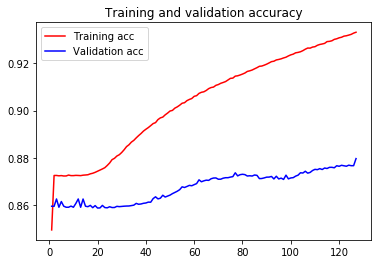

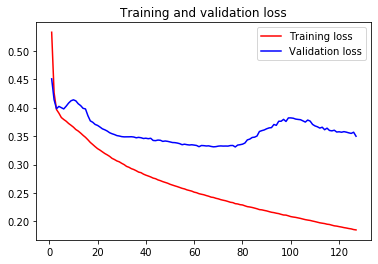

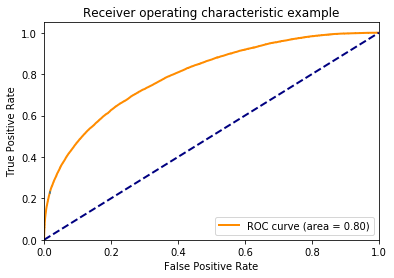

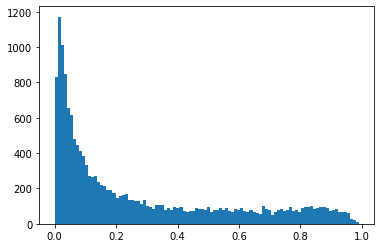

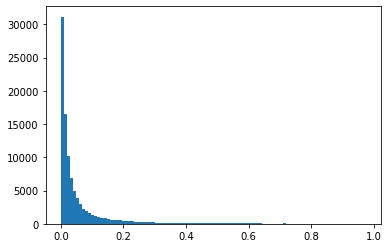

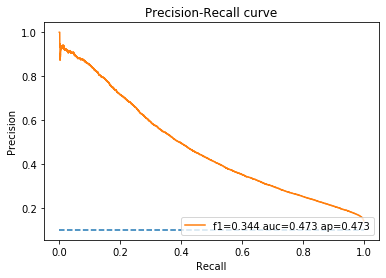


 BASELINE MODEL: 

[[98675     0]
 [16125     0]] 0.86 0.5

 RANDOM MODEL: 

[[49267 49408]
 [ 7998  8127]] 0.5 0.5


In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import random
random.seed(7)


def generator(X, Y, batch_size=32, train=True):
    while True:
        for offset in range(0, len(X), batch_size):
            X_batch = np.stack(X[offset:offset+batch_size], axis=0)
            
            if train:
                Y_batch = np.stack(Y[offset:offset+batch_size], axis=0)
            
                Y_batch_ = np.array(list(map(np.sum, Y_batch)))
                Y_batch_[Y_batch_ < 10] = 0
                Y_batch_[Y_batch_ >= 10] = 1
                

                Y_f = np.array([Y_batch_[e].flatten() for e in range(Y_batch_.shape[0])])
                yield (X_batch, Y_f)
            
            else:
                yield X_batch

structure_ids = []   
for line in open('./structures lists/stucture ids homo sapiens.txt', 'r'):
    line = line.strip('\n').lower()
    structure_ids.append(line)
for line in open('./structures lists/stucture ids synthetic construct.txt', 'r'):
    line = line.strip('\n').lower()
    structure_ids.append(line)
for line in open('./structures lists/stucture ids virus.txt', 'r'):
    line = line.strip('\n').lower()
    structure_ids.append(line)

structure_ids.remove('1a9n')
structure_ids.remove('2adc')
random.shuffle(structure_ids)
print(len(structure_ids))

num_test = int(len(structure_ids)*0.3)

X_train = []
X_test = []
Y_train = []
Y_test = []
num_aa_train = 0
num_aa_test = 0
for j, structure_id in enumerate(structure_ids):
    if j <= num_test:
        protein = np.load('../data/voxelized data 14x14x17 2/' + structure_id + '_protein.npy')
        rna = np.load('../data/voxelized data 14x14x17 2/' + structure_id + '_rna_3D.npy')

        X_test.extend(protein[:, :, :, :, :3])
        Y_test.extend(rna)
        num_aa_test +=len(rna)
        

    else:
        protein_1 = np.load('../data/voxelized data 14x14x17 2/' + structure_id + '_protein.npy')
        rna_1 = np.load('../data/voxelized data 14x14x17 2/' + structure_id + '_rna_3D.npy')
        protein_2 = np.load('../data/voxelized data 14x14x17 2 aug/' + structure_id + '_protein.npy')
        rna_2 = np.load('../data/voxelized data 14x14x17 2 aug/' + structure_id + '_rna_3D.npy')
        
        X_train.extend(protein_1[:, :, :, :, :3])
        Y_train.extend(rna_1)
        num_aa_train +=len(rna_1)
        X_train.extend(protein_2[:, :, :, :, :3])
        Y_train.extend(rna_2)
        num_aa_train +=len(rna_2)



Y_test = np.stack(Y_test, axis=0)
Y_test_ = np.array(list(map(np.sum, Y_test)))
Y_test_[Y_test_ < 10] = 0
Y_test_[Y_test_ >= 10] = 1


print(Y_test.shape)

n_steps_train = int(num_aa_train/400) 
n_steps_test = int(num_aa_test/400)

print(num_aa_train, num_aa_test)


generator_train = generator(X_train, Y_train, 400, True)
generator_validation = generator(X_test, Y_test, 400, True)
generator_test = generator(X_test, Y_test, 400, False)

ins = tf.keras.layers.Input((14, 14, 17, 3))
con1 = tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu')(ins)
con2 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu')(con1)
con3 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu')(con2)
maxp1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))(con3)
con4 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu')(maxp1)
con5 = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(con4)
con6 = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(con5)
maxp2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))(con6)
con7 = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(maxp2)
con8 = tf.keras.layers.Conv3D(filters=8, kernel_size=(3, 3, 3), padding='same', activation='relu')(con7)
con9 = tf.keras.layers.Conv3D(filters=4, kernel_size=(3, 3, 3), padding='same', activation='relu')(con8)
maxp3 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))(con9)
batch = tf.keras.layers.BatchNormalization()(maxp3)
flat = tf.keras.layers.Flatten()(batch)
dens2 = tf.keras.layers.Dense(units=256, activation='relu')(flat)
drop2 = tf.keras.layers.Dropout(0.6)(dens2)
outs = tf.keras.layers.Dense(units=1, activation='sigmoid')(drop2)
model = tf.keras.models.Model(inputs=ins, outputs=outs)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.00001), metrics=['accuracy', 'mse'])

model.summary()

# checkpoint
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min', min_delta=0.0001)
# mc = tf.keras.callbacks.ModelCheckpoint("weights_best.hdf5", monitor='val_loss', verbose=0, save_best_only=True, mode='min')

# model.fit(X_train, Y_train_f, validation_split=0.33, epochs=1, batch_size=200, callbacks=callbacks_list, verbose=0)
history = model.fit_generator(generator_train, steps_per_epoch=n_steps_train, epochs=1000, 
                    validation_data = generator_validation, validation_steps=n_steps_test, callbacks=[es], verbose=0)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('accuracy_1_all_aug')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss_1_all_aug')


# model_best = model
# model_best.load_weights("weights_best.hdf5")
# print(model.evaluate(X_test, Y_test, verbose=0, batch_size=100))
# model_best.save('model_cnn_15_2.h5')
# Y_pred = model_best.predict(X_test, batch_size=200)
Y_pred_prob = model.predict_generator(generator_test, steps=n_steps_test)
print(Y_pred_prob.shape)

#CNN
Y_pred_ = np.copy(Y_pred_prob)
Y_pred_[Y_pred_ >= 0.5] = 1
Y_pred_[Y_pred_ < 0.5] = 0

print(Y_pred_.shape)
print(Y_test_.shape)
Y_test_ = Y_test_[:Y_pred_.shape[0]]


print('CNN: \n')
confusion_matrix = sklearn.metrics.confusion_matrix(Y_test_, Y_pred_)
accuracy = np.sum(np.trace(confusion_matrix))/np.sum(confusion_matrix)
auc = sklearn.metrics.roc_auc_score(Y_test_, Y_pred_prob)

print(confusion_matrix, np.round(accuracy, 2), np.round(auc, 2))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y_test_, Y_pred_prob)
our_thr = np.where(np.round(thresholds, 2) == 0.5)[0]
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr[our_thr], tpr[our_thr])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc_curve_aug')
plt.show()

plt.hist(Y_pred_prob[np.where(Y_test_==1)[0]], bins=100)
plt.savefig('positive_hist_aug')
plt.show()

plt.hist(Y_pred_prob[np.where(Y_test_==0)[0]], bins=100)
plt.savefig('negative_hist_aug')
plt.show()

precision, recall, _ = sklearn.metrics.precision_recall_curve(Y_test_, Y_pred_prob)
# calculate F1 score
f1 = sklearn.metrics.f1_score(Y_test_, Y_pred_)
# calculate precision-recall AUC
pr_auc = sklearn.metrics.auc(recall, precision)
# calculate average precision score
ap = sklearn.metrics.average_precision_score(Y_test_, Y_pred_prob)

plt.plot([0, 1], [0.1, 0.1], linestyle='--')
plt.plot(recall, precision, label='f1=%.3f auc=%.3f ap=%.3f' % (f1, pr_auc, ap))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()


# baseline model
# predict all zeros; at least 50% correct predictions because there are 1/2 of negative examples
Y_pred_base = np.zeros(Y_test_.shape)

# po = np.sum(Y_train, axis=0)/Y_train.shape[0]
# po[po >= 0.5] = 1
# po[po < 0.5] = 0
# Y_pred_base = np.tile(po, (Y_test.shape[0],1))

print(f'\n BASELINE MODEL: \n')
confusion_matrix_base = sklearn.metrics.confusion_matrix(Y_test_, Y_pred_base)
accuracy_base = np.sum(np.trace(confusion_matrix_base))/np.sum(confusion_matrix_base)
auc_base = sklearn.metrics.roc_auc_score(Y_test_, Y_pred_base)

print(confusion_matrix_base, np.round(accuracy_base, 2), np.round(auc_base, 2))

#random model
Y_pred_random = np.random.random(Y_test_.shape)
Y_pred_random[Y_pred_random >= 0.5] = 1
Y_pred_random[Y_pred_random < 0.5] = 0

print(f'\n RANDOM MODEL: \n')
confusion_matrix_random = sklearn.metrics.confusion_matrix(Y_test_, Y_pred_random)
accuracy_random = np.sum(np.trace(confusion_matrix_random))/np.sum(confusion_matrix_random)
auc_random = sklearn.metrics.roc_auc_score(Y_test_, Y_pred_random)

print(confusion_matrix_random, np.round(accuracy_random, 2), np.round(auc_random, 2))